In [26]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from variational_method.method import method
import variational_method.metrics as metrics

In [2]:
def super_gauss(x, y, a, N):
    """
    Супергаусс на сетке x,y с параметрами a, N
    :param x: сетка по x
    :param y: сетка по y
    :param a: параметр, отвечает за размер области, которую срезает супергаусс
    :param N: отвечает за "крутизну" супергаусс, чем больше, тем быстрее функция стремится к 0
    :return: 2d array
    """
    return np.exp(-((x**2 + y**2) / a**2) ** N)


def mse(orig, restored):
    return np.linalg.norm(orig - restored) / np.sqrt(np.prod(restored.shape))


def normalize(front):
    """
    Нормирует исходный волновой фронт на квадрат [-1, 1] x [-1, 1]
    :param front: волновой фронт
    :return: отнормированный волновой фронт
    """
    tmp = front
    tmp -= tmp.min()
    tmp /= tmp.max()
    return tmp


def get_mask(cernike_gauss, front_part, step = 0.05):
    front = cernike_gauss
    rad = front[front.shape[0]//2][0:front.shape[1]//2]
    ans = np.where(rad[0:np.argmax(rad) + 1] < np.max(rad) , 0, rad[0:np.argmax(rad) + 1])

    radius = front.shape[0]//2 - (np.argmax(rad) + 1)

    radius = radius*1.0 / (front.shape[0]//2)

    mask = grid_x**2 + grid_y**2 <  radius
    cutoff = 1
    while np.max(front*mask) / np.max(front) > front_part:
        cutoff -= step
        mask = grid_x**2 + grid_y**2 <  radius * cutoff
        if cutoff < 0:
            break
    return mask

def L2_mse (u, v, mask=None):
    if mask is None:
        mask = np.ones(u.shape)
    return np.linalg.norm(u * mask  - v * mask) / np.sqrt(np.count_nonzero(u * mask))

In [3]:
cernikes = dict()
cernikes['r^2'] = lambda x, y: x**2 + y**2
cernikes["r^2'x"] = lambda x, y: 2 * x
cernikes["r^2'y"] = lambda x, y: 2 * y
NORMALIZE = False
gauss_rads = np.linspace(0.2, 1.0, 10)
U_n = 512
grid_x, grid_y = np.mgrid[-1:1:1j*U_n, -1:1:1j*U_n]
U_h = grid_x[1,0] - grid_x[0,0]
s_gausses = dict()
for r in gauss_rads:
    s_gausses[r] = super_gauss(grid_x, grid_y, r, 2)
print(gauss_rads)

[0.2        0.28888889 0.37777778 0.46666667 0.55555556 0.64444444
 0.73333333 0.82222222 0.91111111 1.        ]


Text(0.5,1,'Производная по y')

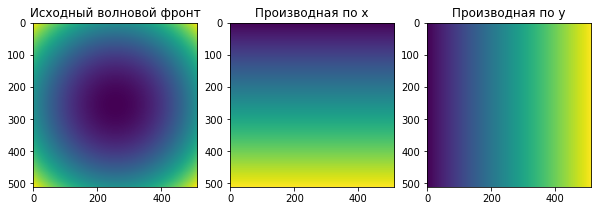

In [4]:
fig, ax = plt.subplots(1, 3, figsize = (10, 5))
ax[0].imshow(cernikes['r^2'](grid_x, grid_y))
ax[1].imshow(cernikes["r^2'x"](grid_x, grid_y))
ax[2].imshow(cernikes["r^2'y"](grid_x, grid_y))
ax[0].set_title('Исходный волновой фронт')
ax[1].set_title('Производная по x')
ax[2].set_title('Производная по y')

In [5]:
cernikes_gauss = dict()
for i, r in enumerate(gauss_rads):
    if NORMALIZE:
        front = normalize(cernikes['r^2'](grid_x, grid_y))
        front *= s_gausses[r]
        cernikes_gauss[r] = normalize(front)
    else:
        cernikes_gauss[r] = cernikes['r^2'](grid_x, grid_y) * s_gausses[r]

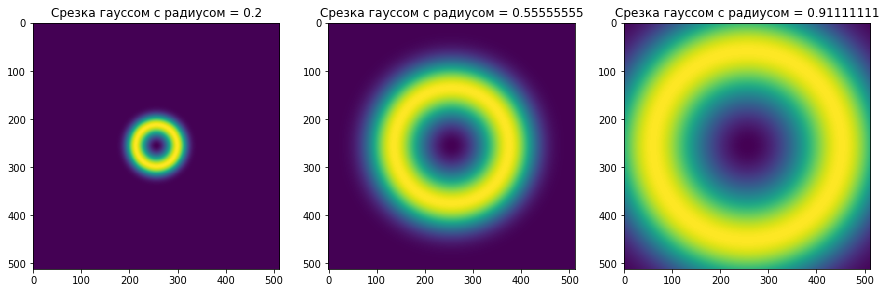

In [8]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
for i, r in enumerate([gauss_rads[0], gauss_rads[4], gauss_rads[8]]):
    ax[i].imshow(cernikes_gauss[r])
    ax[i].set_title('Срезка гауссом с радиусом = ' + str(r)[0:10])

In [11]:
restored_fronts = dict()
for r in gauss_rads:
    restored_fronts[r] = method(cernikes["r^2'x"](grid_x, grid_y), cernikes["r^2'y"](grid_x, grid_y),
                               U_h, U_h, alpha = 0.0001, gamma = 0.002)
    if NORMALIZE:
        restored_fronts[r] = normalize(restored_fronts[r])
        restored_fronts[r] *= s_gausses[r]
        restored_fronts[r] = normalize(restored_fronts[r])
    else:
        restored_fronts[r] *= s_gausses[r]

In [47]:
mses, C, L2 = [], [], []
for i, r in enumerate(gauss_rads):
    mask = get_mask(cernikes_gauss[r], 0.7)
    mses.append(mse(restored_fronts[r] * mask, cernikes['r^2'](grid_x, grid_y) * mask))
    print("MSE (r = " + str(r) + ")",  mses[i])

    C.append(metrics.C(restored_fronts[r] , cernikes['r^2'](grid_x, grid_y)))
    print("C (r = " + str(r) + ")",  C[i])
    
    L2.append(metrics.L2(restored_fronts[r] * mask , cernikes['r^2'](grid_x, grid_y) * mask))
    print("L2 (r = " + str(r) + ")",  L2[i])
    print("-" * 100)

MSE (r = 0.2) 0.25848062107738423
C (r = 0.2) 1.644717484259215
L2 (r = 0.2) 3.2288160891545785
----------------------------------------------------------------------------------------------------
MSE (r = 0.2888888888888889) 0.43508791152388865
C (r = 0.2888888888888889) 1.6447175307103128
L2 (r = 0.2888888888888889) 3.1554257201169174
----------------------------------------------------------------------------------------------------
MSE (r = 0.37777777777777777) 0.5948013686255886
C (r = 0.37777777777777777) 1.6447175398261045
L2 (r = 0.37777777777777777) 3.089570908068184
----------------------------------------------------------------------------------------------------
MSE (r = 0.4666666666666667) 0.6651133111304853
C (r = 0.4666666666666667) 1.6447175425288822
L2 (r = 0.4666666666666667) 3.1045359191419117
----------------------------------------------------------------------------------------------------
MSE (r = 0.5555555555555556) 0.8165056842029782
C (r = 0.5555555555555556)

Text(0,0.5,'C')

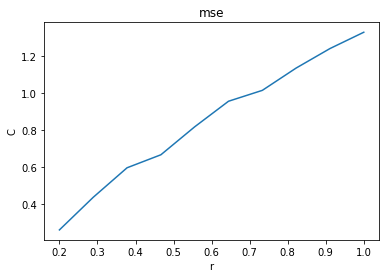

In [48]:
plt.plot(gauss_rads, mses)
plt.title('mse')
plt.xlabel('r')
plt.ylabel('C')

Text(0,0.5,'C')

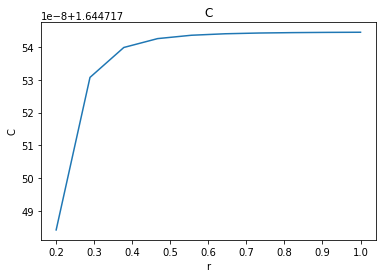

In [49]:
plt.plot(gauss_rads, C)
plt.title('C')
plt.xlabel('r')
plt.ylabel('C')

Text(0,0.5,'L2')

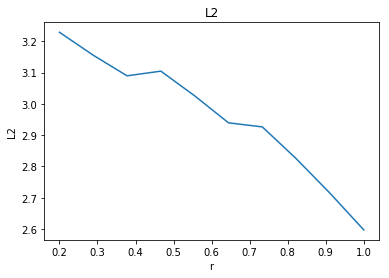

In [50]:
plt.plot(gauss_rads, L2)
plt.title('L2')
plt.xlabel('r')
plt.ylabel('L2')